This code is inspired from the code available here: https://www.kaggle.com/leighplt/pytorch-fcn-resnet50

# Import libraries

In [62]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

In [63]:
import rasterio
from rasterio.windows import Window

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

# Configuration 

In [65]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [66]:
DATA_PATH = 'hubmap-kidney-segmentation/hubmap-kidney-segmentation_original'
EPOCHES = 2
BATCH_SIZE = 56
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

# UDF

In [67]:
# used for converting the decoded image to rle mask
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)): 
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()     # https://numba.pydata.org/numba-doc/latest/user/5minguide.html
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1:
        flag = False
        points.append(1)
    else:
        flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [68]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=64, threshold = 500):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, filename in enumerate(self.csv.index.values):
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(
                    self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window,
                                   min_overlap=self.overlap)
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                        self.slices.append([i,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        
        idx = self.slices[index][0]
        filename = self.files[idx]
        x1,x2,y1,y2 = self.slices[index][1:] 
        with rasterio.open(filename, transform = identity) as dataset:
            channels = [1,2,3] if dataset.count == 3 else [1,1,1]
            image = dataset.read(channels,window=Window.from_slices((x1,x2),(y1,y2)))    
            image = np.moveaxis(image, 0, -1)
            
        mask = self.masks[idx][x1:x2,y1:y2]
        
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# Data

## Data Cleaning

In [69]:
HuBMAP_DS_information = pd.read_csv(DATA_PATH+"/HuBMAP-20-dataset_information.csv") 
df_info=HuBMAP_DS_information
df_info_idx= []
list1=["57512b7f1.tiff","3589adb90.tiff","aa05346ff.tiff","2ec3f1bb9.tiff","d488c759a.tiff"]
for i in range(len(df_info)):
    if df_info["image_file"][i] in list1:
        df_info_idx.append(i)
df_info_idx
df_info=df_info.drop(df_info.index[df_info_idx])
len(df_info)

15

## Data processing

In [84]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

trfm = A.Compose([
    A.Resize(250,500), #dorra
    A.HorizontalFlip(p=0.5),
    A.ColorJitter (brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3)
])

ds = HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

## Split train, validation and test

In [85]:
valid_idx, train_idx, test_idx = [], [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 4 :
        valid_idx.append(i)
    else:
        if ds.slices[i][0] == 8:
            test_idx.append(i)
        else:
            train_idx.append(i)
            
train_ds = D.Subset(ds, train_idx)
valid_ds = D.Subset(ds, valid_idx)
test_ds = D.Subset(ds, test_idx)
print("train_size: ",len(train_idx), "\nvalidation_size: ",len(valid_idx),"\ntest_size: ",len(test_idx) )

train_size:  3255 
validation_size:  349 
test_size:  417


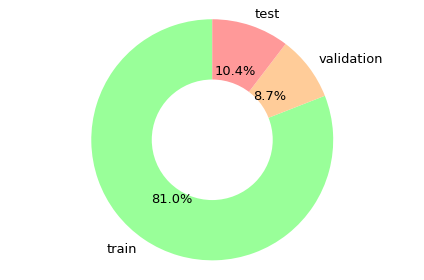

In [86]:
# Pie chart
labels = ['train', 'validation','test']
sizes = [len(train_idx), len(valid_idx),  len(test_idx)]
#colors
colors = ['#99ff99' ,'#ffcc99', '#ff9999','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90,textprops={'fontsize': 13})
#draw circle
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [87]:
# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
tloader = D.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Input data visualization

In [88]:
df_info

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
5,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
6,c68fe75ea.tiff,49780,26840,c68fe75ea-anatomical-structure.json,c68fe75ea.json,67112,White,Not Hispanic or Latino,Male,56,91.2,167.6,32.5,Left,80,20
7,095bf7a1f.tiff,39000,38160,095bf7a1f-anatomical-structure.json,095bf7a1f.json,68250,White,Not Hispanic or Latino,Female,44,71.7,160.0,28.0,Right,65,35
8,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
10,4ef6695ce.tiff,50680,39960,4ef6695ce-anatomical-structure.json,4ef6695ce.json,66999,White,Not Hispanic or Latino,Male,56,91.4,181.6,27.7,Right,65,35
11,aaa6a05cc.tiff,13013,18484,aaa6a05cc-anatomical-structure.json,aaa6a05cc.json,65631,White,Not Hispanic or Latino,Female,73,NaN,NaN,NaN,Left,75,25
12,b9a3865fc.tiff,40429,31295,b9a3865fc-anatomical-structure.json,b9a3865fc.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45


<AxesSubplot:xlabel='weight_kilograms', ylabel='Count'>

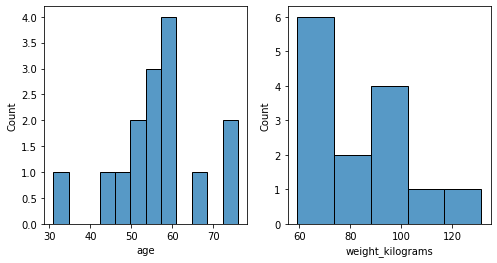

In [89]:

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sn.histplot(x="age", data=df_info)
plt.subplot(1, 2, 2)
sn.histplot(x="weight_kilograms", data=df_info)

# Model 

In [18]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [19]:
model = get_model()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
model = nn.DataParallel(model)
model.to(DEVICE);
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

Let's use 8 GPUs!


In [20]:
model

DataParallel(
  (module): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [21]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    dice_values = []

    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        dice =1- dice_fn(output.sigmoid(), target)
        losses.append(loss.item())
        dice_values.append(dice.item())
        
    return np.array(losses).mean(),np.array(dice_values).mean()

In [22]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [23]:
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

## train model

In [24]:
### Table for results
header = r'''
        Train         | Valid
Epoch |  Loss |  dice |  Loss |  dice | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*4 + '\u2502{:6.2f}'

In [25]:
print(header)
epoches=[]
TrainLoss=[]
TrainDice=[]
ValidLoss=[]
ValidDice=[]
TrainLossMedian=[]
TrainDiceMedian=[]
times=[]

for epoch in range(1, EPOCHES+1):
    losses = []
    dice_values=[]
  
    start_time = time.time()
    model.train()
    for image, target in loader:
        i=0
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        model_output = model(image)
        output = model(image)['out']
        loss = loss_fn(output, target)
        dice = 1- dice_fn(output.sigmoid(), target)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        dice_values.append(dice.item())
        
    vloss,vdice= validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(),np.array(dice_values).mean(), vloss,vdice,
                              (time.time()-start_time)/60**1))    
    epoches.append(epoch)
    TrainLoss.append(np.array(losses).mean())
    TrainDice.append(np.array(dice_values).mean())
    TrainLossMedian.append(statistics.median(np.array(losses)))
    TrainDiceMedian.append(statistics.median(np.array(dice_values)))
    ValidLoss.append(vloss)
    ValidDice.append(vdice)
    times.append((time.time()-start_time)/60**1)

    losses = []
    dice_values= []


        Train         | Valid
Epoch |  Loss |  dice |  Loss |  dice | Time, m

     1│  0.341│  0.353│  0.246│  0.435│  7.06
     2│  0.217│  0.467│  0.198│  0.520│  5.63
